# Homework 1: Regression and classification


## Regression: download the steam dataset:
https://cseweb.ucsd.edu/classes/fa24/cse258-b/files/steam.json.gz

Experiments in this section will only use the “time played” (d[“hours”]) and the length of the review text (len(d[“text”)]).

In [1]:
import gzip

z = gzip.open("steam.json.gz")
dataset = []
for l in z:
    d = eval(l)
    dataset.append(d)

In [2]:
len(dataset), dataset[0]

(175000,
 {'hours': 0.3,
  'gameID': 'g35322304',
  'hours_transformed': 0.37851162325372983,
  'early_access': False,
  'date': '2015-04-08',
  'text': '+1',
  'userID': 'u55351001'})

 - Implement regression on time played (hours) using the length of the review and a bias term. Use an 80%/20% training/test split. Use sklearn’s linear_model.LinearRegression. Report the MSE on the test set.

In [3]:
import numpy as np

X = np.array([len(row["text"]) for row in dataset]).reshape(-1, 1)
y = np.array([row["hours"] for row in dataset])
print(X.shape, y.shape)

(175000, 1) (175000,)


In [4]:
X_train, y_train = X[:int(0.8 * len(X))], y[:int(0.8 * len(y))]
X_test, y_test = X[int(0.8 * len(X)):], y[int(0.8 * len(y)):]
print(X_train.shape, X_test.shape)

(140000, 1) (35000, 1)


In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)

q1_mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
q1_mse

76047.19578054463

- Delete outliers from the training set. Keep the bottom 90% of time played values. Report the MSE on the test set, as well as the MAE on the test set.

In [7]:
def delete_outliers(X, y, percentile=90):
    threshold = np.percentile(y, percentile)
    return X[y <= threshold], y[y <= threshold]

X_train_without_outliers, y_train_without_outliers = delete_outliers(X_train, y_train)
print(X_train_without_outliers.shape)

(126000, 1)


In [8]:
model = LinearRegression()
model.fit(X_train_without_outliers, y_train_without_outliers)

LinearRegression()

In [9]:
y_pred = model.predict(X_test)

q2_mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
q2_mse

78496.18922226882

In [10]:
from sklearn.metrics import mean_absolute_error

y_pred = model.predict(X_test)

q2_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
q2_mae

64.2830186993766

- Transform the target variable by taking log_2(y + 1). After performing regression on the test set, invert the transform (so that your model still predicts a number of hours), and report the MSE on the test set.

In [11]:
def trans(y):
    return np.log2(y + 1)

# Invert the transformation
def inv_trans(y):
    return (2 ** y) - 1

y_train_trans = trans(y_train)

model = LinearRegression()
model.fit(X_train, y_train_trans)

y_pred = model.predict(X_test)
y_pred = inv_trans(y_pred)

q3_mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
q3_mse

79035.51797861399

In [12]:
q3_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
q3_mae

63.37348865035023

- Build a regressor that optimizes the MAE rather than the MSE (see e.g. https://stackoverflow.com/questions/71534025/how-mae-loss-is-optimized-with-sgd-optimizer-in-sklearn). Report the MSE and the MAE on the test set

In [13]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(
    loss="epsilon_insensitive",
    epsilon=0,
    random_state=1
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

q4_mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
q4_mse

78676.09973078885

In [14]:
q4_mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
q4_mae

71.77980745936205

## Classification: 

download the German Credit dataset: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

- Implement a logistic regressor (sklearn’s linear_model.LogisticRegression) to predict the target variable (credit = good). Implement a 80/20 training/test split. Use a regularization value of C = 1. Report the accuracy and TPR on the test set.

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

def tpr_fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return TPR, FPR

german_credit = np.loadtxt("german.data-numeric")
attrs = german_credit[:, :-1] 
labels = 2 - german_credit[:, -1] # (1 = Good,  2 = Bad) -> (0 = Bad, 1 = good)

X_train, y_train = attrs[:int(0.8 * len(attrs))], labels[:int(0.8 * len(labels))]
X_test, y_test = attrs[int(0.8 * len(attrs)):], labels[int(0.8 * len(labels)):]

model = LogisticRegression(C=1, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

q5_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
q5_tpr, q5_fpr = tpr_fpr(y_true=y_test, y_pred=y_pred)
q5_acc, q5_tpr, q5_fpr

(0.79, 0.8848920863309353, 0.4262295081967213)

For the following, treat “foreign worker” as the “sensitive attribute” i.e., z=1 for foreign workers and z=0 for others.

- Report the TPR for Z=0 and Z=1.

In [16]:
z = (attrs[:, 19] == 1).astype(int)
z_test = z[-len(y_test):]

def tpr(y_true, y_pred, z, category):
    indices = (z == category)
    y_true = y_true[indices]
    y_pred = y_pred[indices]
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    return TPR

z_0_TPR = tpr(y_true=y_test, y_pred=y_pred, z=z_test, category=0)
z_1_TPR = tpr(y_true=y_test, y_pred=y_pred, z=z_test, category=1)
z_0_TPR, z_1_TPR

(0.8879310344827587, 0.8695652173913043)

- By changing the classifier thresholds, generate an ROC curve for your classifier. Report the TPR when the FPR is (as close as possible to) 0.8.

In [17]:
from sklearn.metrics import roc_curve, auc

In [18]:
y_probs = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_probs)

fpr_threshold = 0.8
index = (np.abs(fpr - fpr_threshold)).argmin()
q7_tpr = tpr[index]
q7_tpr

0.9568345323741008

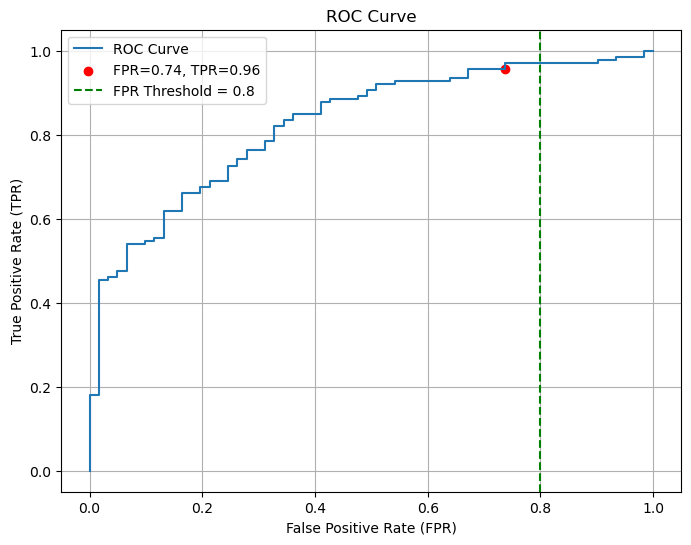

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.scatter(fpr[index], tpr[index], color="red", label=f"FPR={fpr[index]:.2f}, TPR={tpr[index]:.2f}")
plt.axvline(x=fpr_threshold, color="green", linestyle="--", label=f"FPR Threshold = {fpr_threshold}")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

- Use an instance weighting approach (this option is already available in the library implementation) to tune the model such that instances with z=0 have 5x the instance weight of instances with z=1. Report the TPR for Z=0 and Z=1.

In [20]:
def tpr(y_true, y_pred, z, category):
    indices = (z == category)
    y_true = y_true[indices]
    y_pred = y_pred[indices]
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN)
    return TPR

z = (attrs[:, 19] == 1).astype(int)
weights = np.where(z == 0, 5, 1)[:len(y_train)]

weighted_model = LogisticRegression(C=1, max_iter=1000)
weighted_model.fit(X_train, y_train, sample_weight=weights)

y_pred_weighted = weighted_model.predict(X_test)

z_0_TPR_weighted = tpr(y_true=y_test, y_pred=y_pred_weighted, z=z_test, category=0)
z_1_TPR_weighted = tpr(y_true=y_test, y_pred=y_pred_weighted, z=z_test, category=1)

z_0_TPR_weighted, z_1_TPR_weighted

(0.8793103448275862, 0.6521739130434783)

- (harder, 2 marks) Implement a support vector machine (using sklearn). Using your solution from question Q5, generate ROC curves for both the logistic regression model and the support vector machine. Find the point on this curve where the two models intersect, and report the corresponding TPR/FPR values.

In [21]:
from sklearn.svm import SVC

svm = SVC(probability=True, C=1, max_iter=1000)
svm.fit(X_train, y_train)

svm_probas = svm.predict_proba(X_test)[:, 1]
svm_roc_fpr, svm_roc_tpr, svm_roc_thresholds = roc_curve(y_true=y_test, y_score=svm_probas)

In [22]:
lr_probas = model.predict_proba(X_test)[:, 1]
lr_roc_fpr, lr_roc_tpr, lr_roc_thresholds = roc_curve(y_true=y_test, y_score=lr_probas)

In [23]:
print(len(svm_roc_fpr), len(lr_roc_fpr))

71 62


In [24]:
intersection_points = []

for i, (lfpr, ltpr) in enumerate(zip(lr_roc_fpr, lr_roc_tpr)):
    for j, (sfpr, stpr) in enumerate(zip(svm_roc_fpr, svm_roc_tpr)):
        if np.isclose(lfpr, sfpr) and np.isclose(ltpr, stpr):
            intersection_points.append((lfpr, ltpr))

if intersection_points:
    print("Intersection Points:")
    for point in intersection_points:
        print(f"FPR: {point[0]: .4f}, TPR: {point[1]: .4f}")
else:
    print("No exact intersection points found.")

Intersection Points:
FPR:  0.0000, TPR:  0.0000
FPR:  0.0000, TPR:  0.0072
FPR:  0.6393, TPR:  0.9353
FPR:  1.0000, TPR:  1.0000


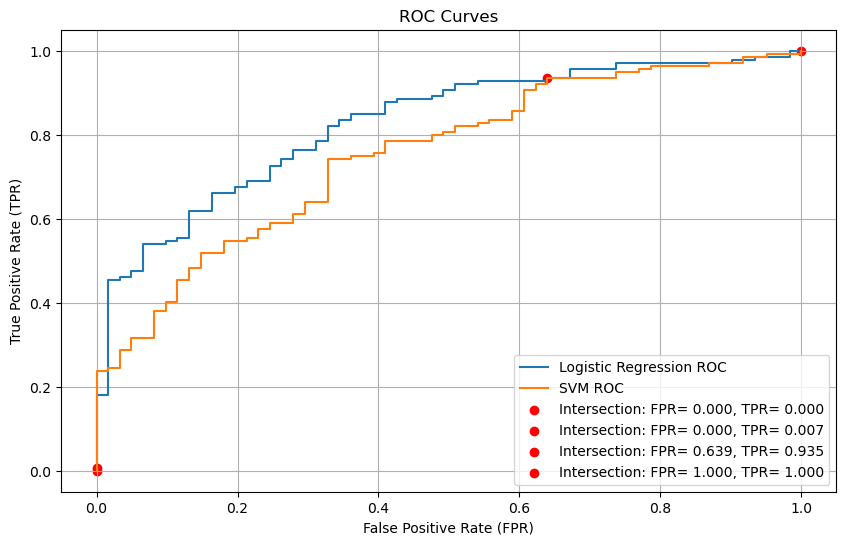

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(lr_roc_fpr, lr_roc_tpr, label="Logistic Regression ROC")
plt.plot(svm_roc_fpr, svm_roc_tpr, label="SVM ROC")
for point in intersection_points:
    plt.scatter(point[0], point[1], color="red", label=f"Intersection: FPR={point[0]: .3f}, TPR={point[1]: .3f}")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves")
plt.legend()
plt.grid()
plt.show()

In [26]:
fpr_q9, tpr_q9 = intersection_points[2][0], intersection_points[2][1]
fpr_q9, tpr_q9

(0.639344262295082, 0.935251798561151)

## Answers

In [27]:
answers = {
    "Q1": q1_mse,          # MSE
    "Q2": [q2_mse, q2_mae], # MSE, MAE
    "Q3": q3_mse,          # MSE
    "Q4": [q4_mse, q4_mae], # MSE, MAE
    "Q5": [q5_acc, q5_tpr], # Accuracy, TPR
    "Q6": [z_0_TPR, z_1_TPR], # TPR_0, TPR_1
    "Q7": q7_tpr,          # TPR
    "Q8": [z_0_TPR_weighted, z_1_TPR_weighted], # TPR_0, TPR_1
    "Q9": [tpr_q9, fpr_q9]  # TPR, FPR
}

answers

{'Q1': 76047.19578054463,
 'Q2': [78496.18922226882, 64.2830186993766],
 'Q3': 79035.51797861399,
 'Q4': [78676.09973078885, 71.77980745936205],
 'Q5': [0.79, 0.8848920863309353],
 'Q6': [0.8879310344827587, 0.8695652173913043],
 'Q7': 0.9568345323741008,
 'Q8': [0.8793103448275862, 0.6521739130434783],
 'Q9': [0.935251798561151, 0.639344262295082]}